# **Proyek Unsupervised Learning: Bank Transaction Dataset for Fraud Detection**

# **1. Perkenalan Dataset**


Berikut beberapa informasi mengenai dataset yang saya gunakan dalam project ini:

1. **Sumber Dataset**:  
   Dataset yang saya dapat dan gunakan dalam project ini didapat dari sumber Kaggle yang dimana merupakan 'Bank Transaction Dataset for Fraud Detection'

> https://www.kaggle.com/datasets/valakhorasani/bank-transaction-dataset-for-fraud-detection

Alasan utama saya menggunakan dataset ini karena saya cukup tertarik untuk mencoba menerapkan project ini ke sebuah konteks permasalahan nyata dan krusial/penting, misalnya disini adalah dalam konteks tansaksi perbankan.
   
2. **Ketentuan dari Dataset**:
   - **Tanpa label**: Pada dataset ini tidak terdapat label transaksi yang merupakan Fraud, melainkan dari dataset ini akan dilakukan analisis menggunakan clustering untuk memberikan label kepada sample yang termasuk kedalam cluster yang berpotensi sebagai Fraud Transaction.
   - **Jumlah Baris**: Jumlah dari dataset ini memiliki total sebanyak 2513 baris data.
   - **Jumlah Kolom**: Jumlah total dari dataset berjumlah 16 kolom.
   - **Tipe Data**: Data memiliki masing-masing **kategorikal** dan **numerikal**.
    - **Kategorikal**:  TransactionType, Location, Channel, CustomerOccupation.
    - **Numerikal**: TransactionAmount, CustomerAge, TransactionDuration, LoginAttempts, AccountBalance.
    - **Identifier atau high-cardinality**: TransactionID, AccountID, DeviceID, IP Address, MerchantID
    - **Timestamp**: TransactionDate, PreviousTransactionDate

# **2. Import Library**

Import berbagai library yang saya gunakan dalam project ini

In [1]:
!pip install feature-engine

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 378.6/378.6 kB 11.4 MB/s eta 0:00:00


In [2]:
# Library utama
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats
# Library sklearn
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, silhouette_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA

from datetime import datetime
from yellowbrick.cluster import KElbowVisualizer
from feature_engine.encoding import CountFrequencyEncoder
from sklearn.feature_selection import RFE
sns.set_style("whitegrid")

# **3. Memuat Dataset**

Pada tahap ini, Anda perlu memuat dataset ke dalam notebook. Jika dataset dalam format CSV, Anda bisa menggunakan pustaka pandas untuk membacanya. Pastikan untuk mengecek beberapa baris awal dataset untuk memahami strukturnya dan memastikan data telah dimuat dengan benar.

Jika dataset berada di Google Drive, pastikan Anda menghubungkan Google Drive ke Colab terlebih dahulu. Setelah dataset berhasil dimuat, langkah berikutnya adalah memeriksa kesesuaian data dan siap untuk dianalisis lebih lanjut.

In [3]:
file_path = "Dataset_clustering.csv"
df = pd.read_csv(file_path)

# **4. Exploratory Data Analysis (EDA)**

Pada bagian **Exploratory Data Analysis (EDA)** ini beberapa hal yang saya lakukan adalah untuk memahami karakteristik dataset yaitu:

1. **Memahami Struktur Data**
   - Tinjau jumlah baris dan kolom dalam dataset.  
   - Tinjau jenis data di setiap kolom (numerikal atau kategorikal).

2. **Menangani Data yang Hilang**  
   - Identifikasi dan analisis data yang hilang (*missing values*). Tentukan langkah-langkah yang diperlukan untuk menangani data yang hilang, seperti pengisian atau penghapusan data tersebut.

3. **Analisis Distribusi dan Korelasi**  
   - Analisis distribusi variabel numerik dengan statistik deskriptif dan visualisasi seperti histogram atau boxplot.  
   - Periksa hubungan antara variabel menggunakan matriks korelasi atau scatter plot.

4. **Visualisasi Data**  
   - Buat visualisasi dasar seperti grafik distribusi dan diagram batang untuk variabel kategorikal.  
   - Menggunakan heatmap atau pairplot untuk menganalisis korelasi antar variabel.

##**A. Memahami Struktur Data**

In [4]:
# Cek total data dan juga kolom yang terdapat pada dataset ini
print(f"Jumlah baris: {df.shape[0]}")
print(f"Jumlah kolom: {df.shape[1]}")

#Cek 5 baris pertama dari data tersebut beserta contoh value yang ada
df.head(), df.info()

Jumlah baris: 2512
Jumlah kolom: 16
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2512 entries, 0 to 2511
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   TransactionID            2512 non-null   object 
 1   AccountID                2512 non-null   object 
 2   TransactionAmount        2512 non-null   float64
 3   TransactionDate          2512 non-null   object 
 4   TransactionType          2512 non-null   object 
 5   Location                 2512 non-null   object 
 6   DeviceID                 2512 non-null   object 
 7   IP Address               2512 non-null   object 
 8   MerchantID               2512 non-null   object 
 9   Channel                  2512 non-null   object 
 10  CustomerAge              2512 non-null   int64  
 11  CustomerOccupation       2512 non-null   object 
 12  TransactionDuration      2512 non-null   int64  
 13  LoginAttempts            2512 non-null   i

(  TransactionID AccountID  TransactionAmount      TransactionDate  \
 0      TX000001   AC00128              14.09  2023-04-11 16:29:14   
 1      TX000002   AC00455             376.24  2023-06-27 16:44:19   
 2      TX000003   AC00019             126.29  2023-07-10 18:16:08   
 3      TX000004   AC00070             184.50  2023-05-05 16:32:11   
 4      TX000005   AC00411              13.45  2023-10-16 17:51:24   
 
   TransactionType   Location DeviceID      IP Address MerchantID Channel  \
 0           Debit  San Diego  D000380  162.198.218.92       M015     ATM   
 1           Debit    Houston  D000051     13.149.61.4       M052     ATM   
 2           Debit       Mesa  D000235  215.97.143.157       M009  Online   
 3           Debit    Raleigh  D000187  200.13.225.150       M002  Online   
 4          Credit    Atlanta  D000308    65.164.3.100       M091  Online   
 
    CustomerAge CustomerOccupation  TransactionDuration  LoginAttempts  \
 0           70             Doctor      

Insight:


---


*   Total dataset berisikan total 2512 baris dengan 16 kolom atau feature
*   Kolom ``` TransactionID, AccountID, IP Address, DeviceID, MerchantID, TransactionDate, PreviousTransactionDate```  tidak saya gunakan sebagai feature tidak berpengaruh dan tidak relevan untuk digunakan dalam clustering fraud detection. Alasan utamanya karena bersifat unik atau identitas.

Dari total 16 kolom tersebut terdapat 3 jenis utama data yaitu:
```
Kolom Numerik: TransactionAmount, CustomerAge, TransactionDuration, LoginAttempts, AccountBalance
Kolom dengan jenis tanggal (tipe data): TransactionDate, PreviousTransactionDate
Kolom Kategorikal: TransactionType, Location, DeviceID, MerchantID, Channel, CustomerOccupation
```

**Format Data**

value dari kolom `TransactionType, Location, Channel, dan Customer Occupation` perlu diubah menjadi bentuk numerik agar bisa digunakan dalam clustering nantinya.

In [5]:
print(df.isnull().sum())

TransactionID              0
AccountID                  0
TransactionAmount          0
TransactionDate            0
TransactionType            0
Location                   0
DeviceID                   0
IP Address                 0
MerchantID                 0
Channel                    0
CustomerAge                0
CustomerOccupation         0
TransactionDuration        0
LoginAttempts              0
AccountBalance             0
PreviousTransactionDate    0
dtype: int64


Insight:

Bila di cek tidak ada value atau data yang hilang dari data tersebut, alasan utama mungkin karena memang data yang diambil dari Kaggle sehingga memang siap pakai untuk pembuatan model.


> Note: Karena tidak ada *missing value* atau *null*, maka proses untuk penganganan data hilang saya lewatkan.



Terdapat data type yang perlu diubah terlebih dahulu sebelum melakukan data splitting dan juga training model

Beberapa yang perlu diubah adalah:
```
* Feature/kolom  tipe kategorikal (TransactionType, Location, Channel, CustomerOccupation)
* Feature/kolom menggunakan tanggal (TransactionDate, PreviousTransactionDate)
```



##**B. Analisis Distribusi Korelasi dan Visualisasi Data**

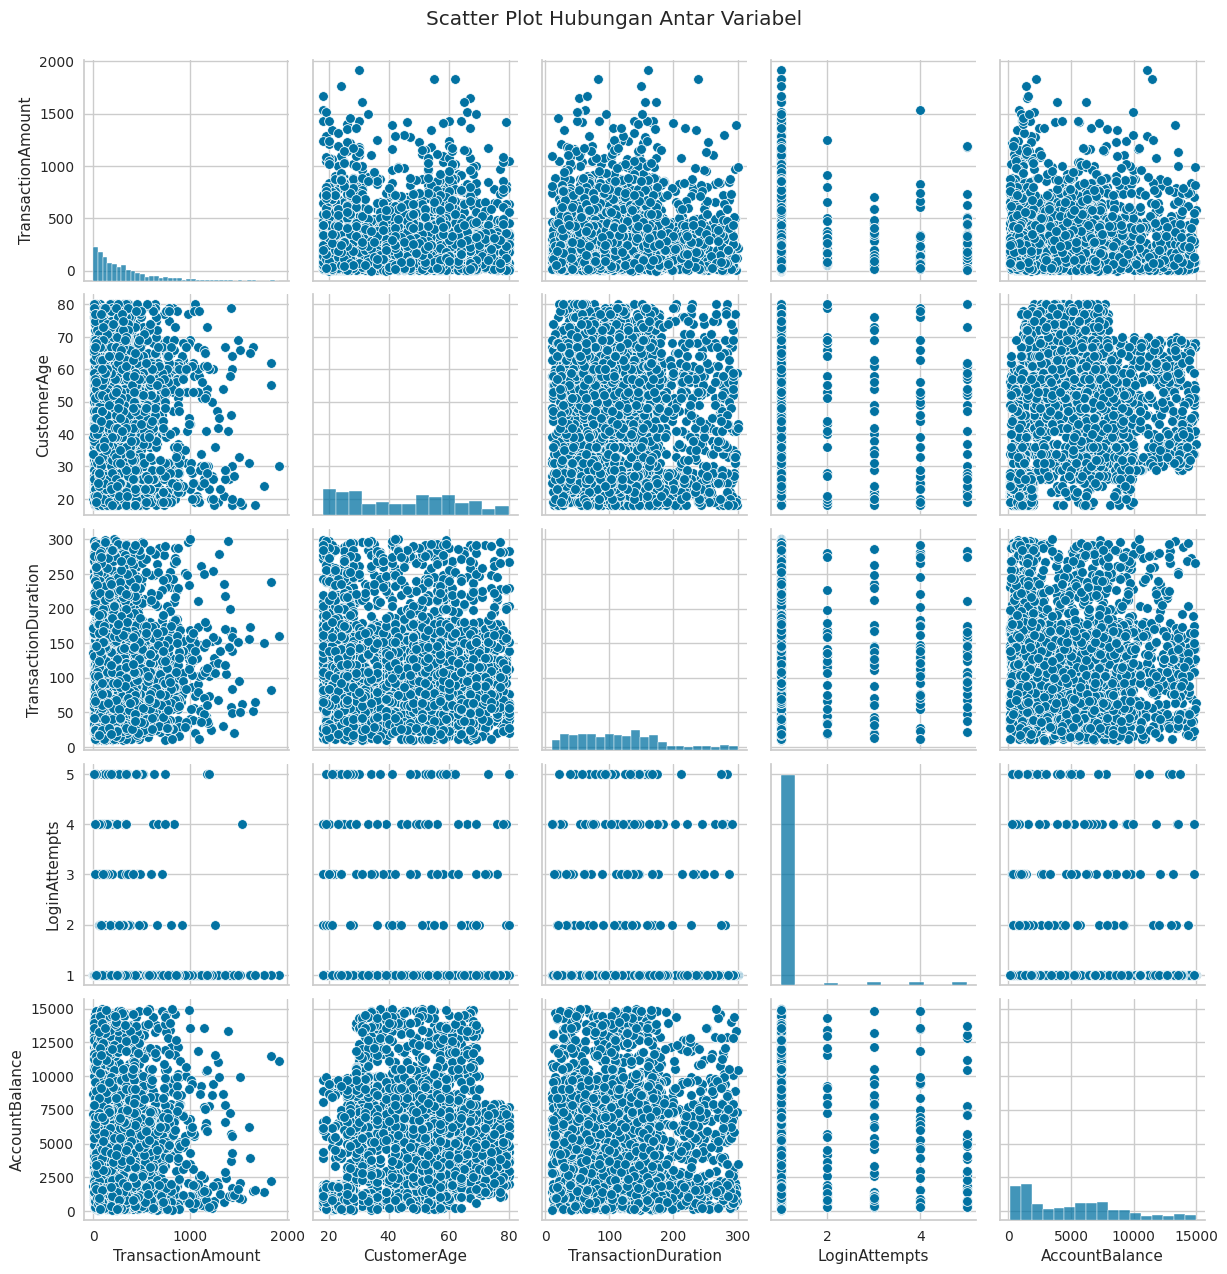

In [6]:
# Hubungan dari setiap kolom yang ada
sns.pairplot(df)
plt.suptitle('Scatter Plot Hubungan Antar Variabel', y=1.02)
plt.show()

<ipython-input-7-eb0b2d10159f>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


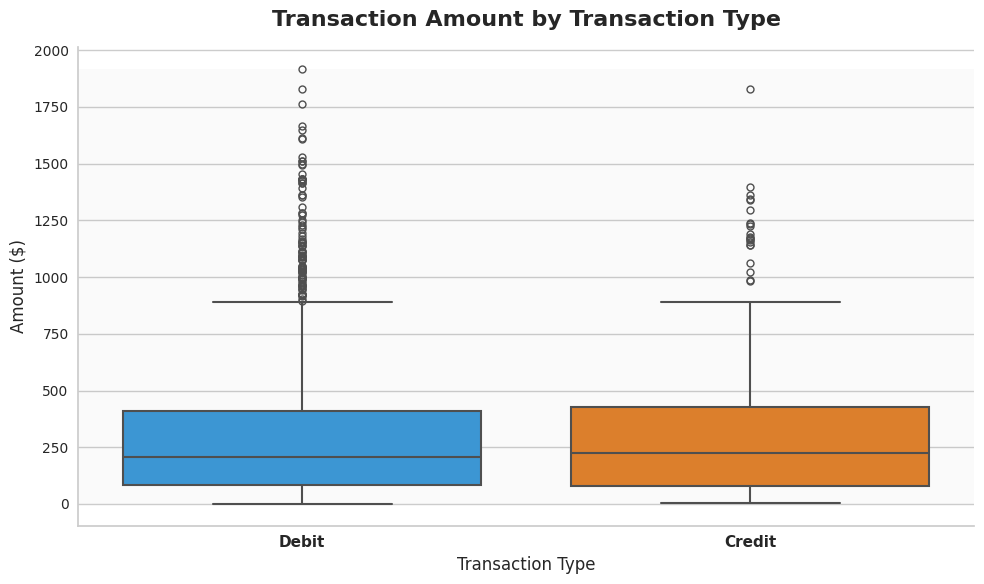

In [7]:
#Visualisasi boxplot yang menampilkan distribusi nilai TransactionAmount berdasarkan TransactionType untuk melihat perbandingan antara transaksi debit dan juga Credit

def style_plot(title=None, xlabel=None, ylabel=None, fig_size=(10, 6)):
    plt.figure(figsize=fig_size)
    if title:
        plt.title(title, fontsize=16, weight='bold', pad=15)
    if xlabel:
        plt.xlabel(xlabel, fontsize=12)
    if ylabel:
        plt.ylabel(ylabel, fontsize=12)
    plt.xticks(fontsize=11, weight='bold')
    plt.yticks(fontsize=10)
    sns.despine()

# Plotting
style_plot(title='Transaction Amount by Transaction Type',
           xlabel='Transaction Type',
           ylabel='Amount ($)')

# Boxplot
sns.boxplot(
    x='TransactionType',
    y='TransactionAmount',
    data=df,
    palette=['#3498db', '#e67e22'],  # Customize colors
    linewidth=1.5,
    fliersize=5,
    saturation=0.9
)

# Highlight background area
plt.axhspan(0, df['TransactionAmount'].max(), facecolor='gray', alpha=0.04)

# Tampilkan plot
plt.tight_layout()
plt.show()

**Insight**: Jumlah transaksi Debit memiliki jumlah yang lebih banyak baik dari jumlah transaksi dan juga jumlah uang yang dikeluarkan.

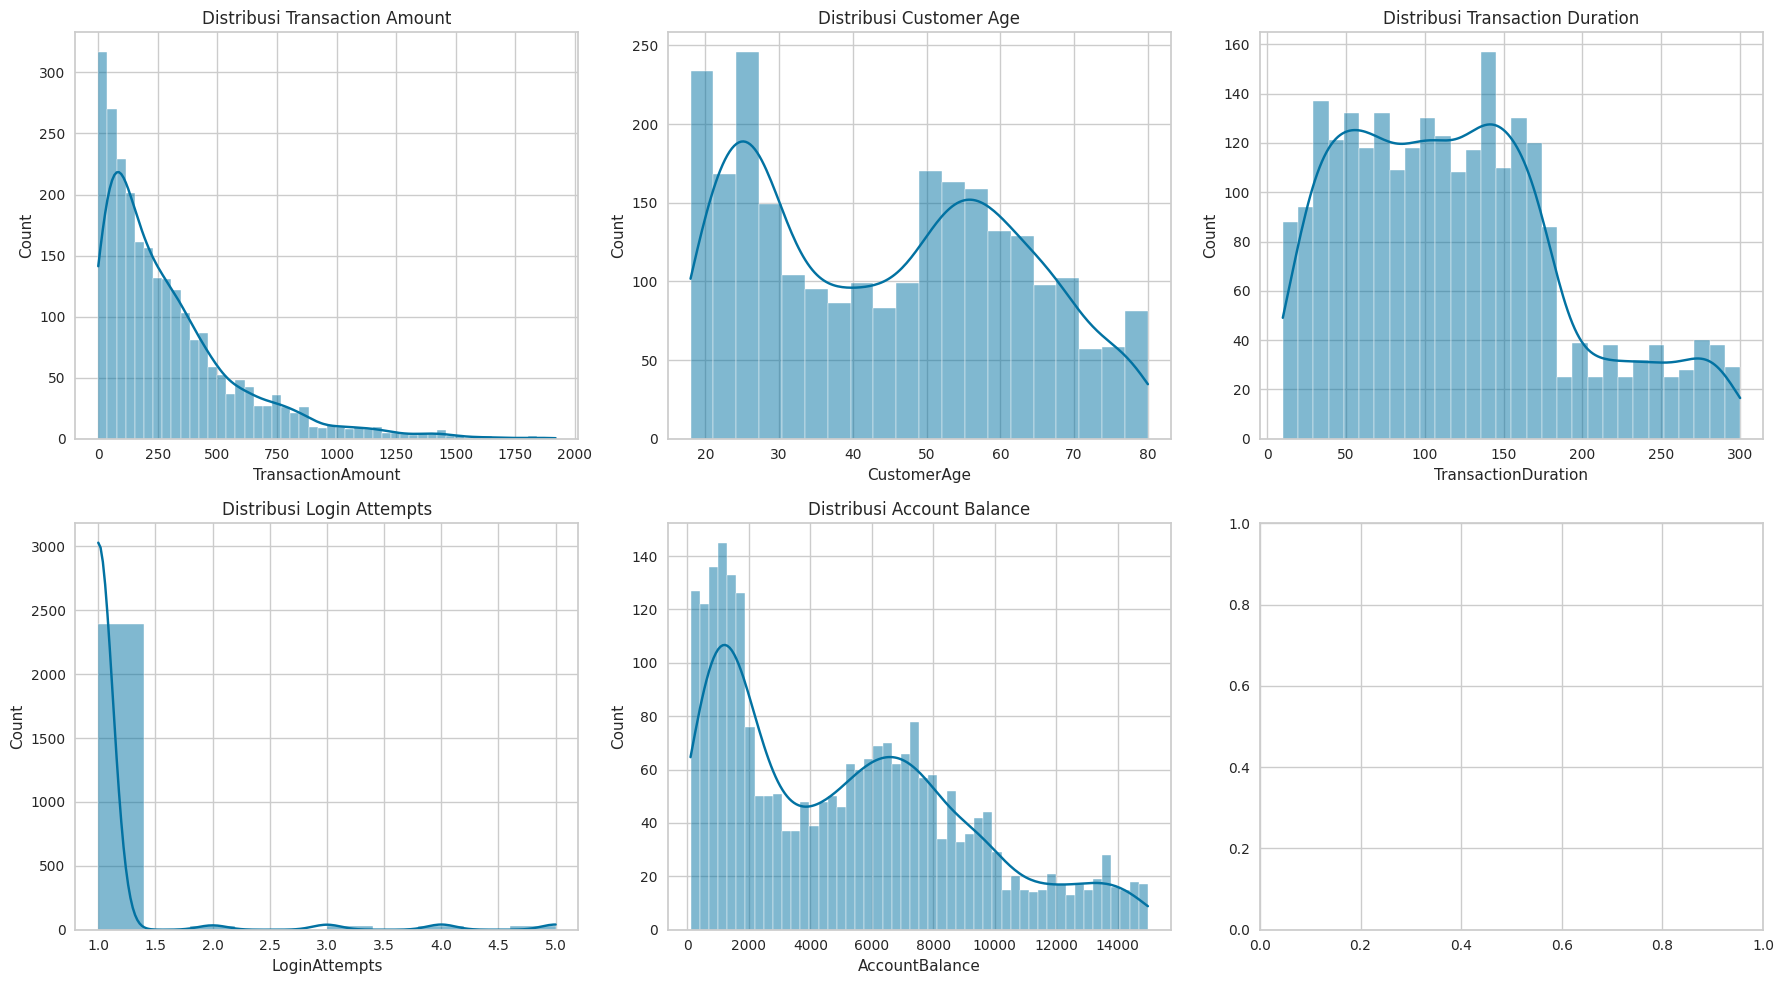

In [8]:
# Pengecekan apakah dari missing value dan juga data-data numerikal
missing_values = df.isnull().sum()
numerical_summary = df.describe()

# Melakukan visualisasi data dari semua
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

sns.histplot(df['TransactionAmount'], bins=50, kde=True, ax=axes[0, 0])
axes[0, 0].set_title('Distribusi Transaction Amount')

sns.histplot(df['CustomerAge'], bins=20, kde=True, ax=axes[0, 1])
axes[0, 1].set_title('Distribusi Customer Age')

sns.histplot(df['TransactionDuration'], bins=30, kde=True, ax=axes[0, 2])
axes[0, 2].set_title('Distribusi Transaction Duration')

sns.histplot(df['LoginAttempts'], bins=10, kde=True, ax=axes[1, 0])
axes[1, 0].set_title('Distribusi Login Attempts')

sns.histplot(df['AccountBalance'], bins=50, kde=True, ax=axes[1, 1])
axes[1, 1].set_title('Distribusi Account Balance')

plt.tight_layout()
plt.show()

Beberapa informasi yang didapatkan dari data tersebut adalah sebagai berikut ini:

*   `TransactionAmount`: Berkisar antara 0.26 hingga 1919.11, dengan mean atau rata-rata dibawah 300 (currency dollar).

*   `CustomerAge`: Berkisar antara 18 hingga 80 tahun, dengan mayoritas pelanggan berusia sekitar 45 tahun.

*   `TransactionDuration`: Durasi dari pembelian produk memiliki jangka waktu antara 10 hingga 300 detik, dengan nilai rata-rata waktu transaksi yaitu 120 detik.

*   `LoginAttempts`: Sebagian besar pelanggan hanya memiliki 1 kali percobaan login, dengan beberapa outlier mencapai 5 kali. Kolom ini yang nanti akan bisa digunakan untuk clustering mana yang termasuk transaksi fraud.

*   `AccountBalance`: Rentangnya besar, dari 101.25 hingga 14,977.99.

Korelasi yang cukup tinggi terlihat pada hubungan antara AccountBalance dengan CustomerAge

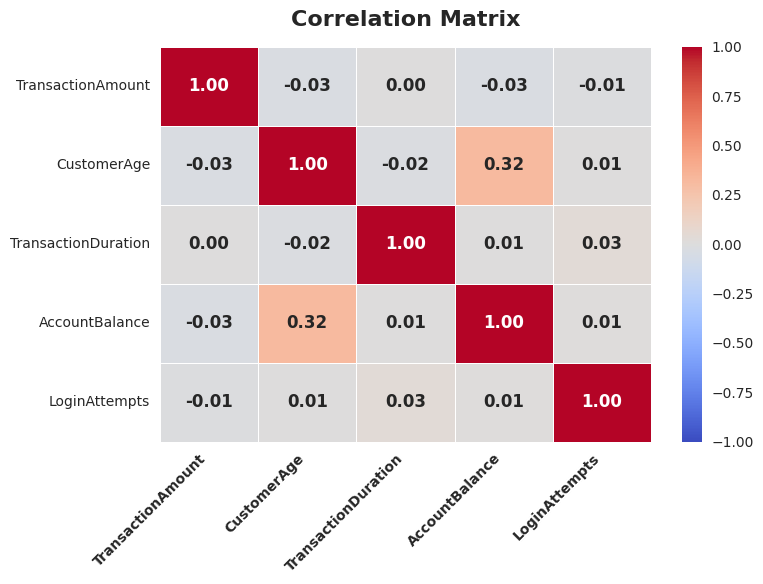

In [9]:
style_plot(fig_size=(8, 6), title='Correlation Matrix')
sns.heatmap(df[['TransactionAmount', 'CustomerAge', 'TransactionDuration', 'AccountBalance', 'LoginAttempts']].corr(),
            annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0,
            fmt='.2f', annot_kws={'size': 12, 'weight': 'bold'}, linewidths=0.5, linecolor='white')
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout()
plt.show()

**Insight**:
Perbandingan penggunaan debit dan juga credit, tipe atau cara fraud yang dilakukan beragam tergantung dari cara transaksi.

<ipython-input-10-63dd78b99638>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='TransactionType', y='TransactionAmount', data=df,


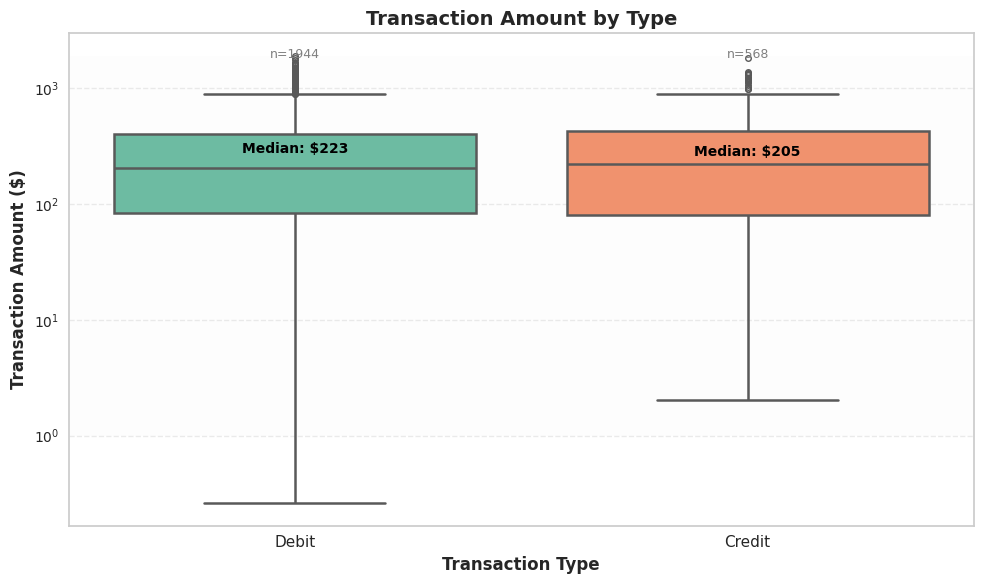

In [10]:
# Ukuran figure
plt.figure(figsize=(10, 6))

# Plot boxplot dengan palette yang ramah mata
sns.boxplot(x='TransactionType', y='TransactionAmount', data=df,
            palette='Set2', linewidth=1.8, fliersize=4, saturation=0.85)

# Menambahkan nilai median ke setiap box
medians = df.groupby('TransactionType')['TransactionAmount'].median().values
for i, median in enumerate(medians):
    plt.text(i, median + 0.02*df['TransactionAmount'].max(),
             f'Median: ${median:,.0f}',
             ha='center', va='bottom', fontsize=10, fontweight='bold', color='black')

# Anotasi jumlah transaksi tiap kategori
counts = df['TransactionType'].value_counts()
for i, count in enumerate(counts):
    plt.text(i, df['TransactionAmount'].max() * 0.95,
             f'n={count}', ha='center', fontsize=9, color='gray')

# Styling tambahan
plt.yscale('log')  # Gunakan log scale jika rentang nilai sangat lebar
plt.xlabel('Transaction Type', fontsize=12, fontweight='bold')
plt.ylabel('Transaction Amount ($)', fontsize=12, fontweight='bold')
plt.title('Transaction Amount by Type', fontsize=14, fontweight='bold')
plt.xticks(fontsize=11)
plt.grid(True, axis='y', linestyle='--', alpha=0.4)

# Highlight background ringan
plt.axhspan(1, df['TransactionAmount'].max(), facecolor='lightgray', alpha=0.04)

plt.tight_layout()
plt.show()

**Insight**: Mapping hubungan antara tipe transaksi dengan channel yang digunakan jumlah uang transaksi yang dikeluarkan untuk masing Debit dan Credit memiliki selisih yang tidak terlalu jauh yaitu:
```
Debit: Median $223
Credit: Median $205
```

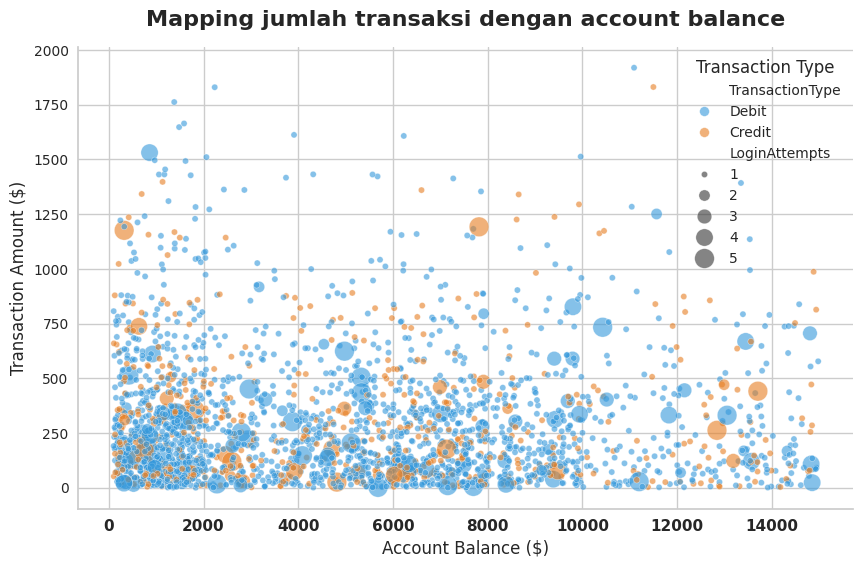

In [11]:
style_plot(fig_size=(10, 6), title='Mapping jumlah transaksi dengan account balance',
           xlabel='Account Balance ($)', ylabel='Transaction Amount ($)')
sns.scatterplot(x='AccountBalance', y='TransactionAmount', data=df, hue='TransactionType',
                palette=['#3498db', '#e67e22'], size='LoginAttempts', sizes=(20, 200), alpha=0.6)
plt.legend(title='Transaction Type', fontsize=10)
plt.show()

**Insight**: Scatter plot yang diberikan menunjukkan hasil yang sangat acak sehingga cukup sulit untuk melakukan clustering terutama bila hanya menggunakan beberapa kolom saja. Dan untuk clustering yang dilakukan kemungkinan tidak dapat dibagi menjadi 2 atau 3 cluster saja melihat pesebaran data yang cukup acak.

<ipython-input-12-27b23916dada>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Location', data=df, palette='viridis', order=top_locations)


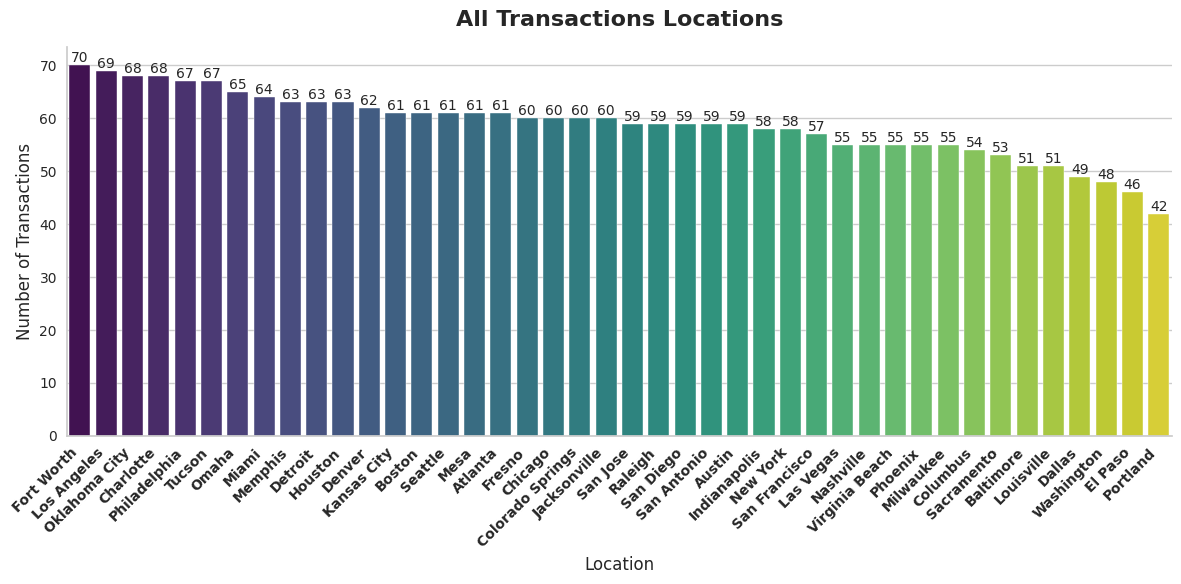

In [12]:
style_plot(fig_size=(12, 6), title='All Transactions Locations', xlabel='Location', ylabel='Number of Transactions')
top_locations = df['Location'].value_counts().index[:-1]
sns.countplot(x='Location', data=df, palette='viridis', order=top_locations)
plt.xticks(rotation=45, ha='right', fontsize=10)
ax = plt.gca()
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

**Insight:** Transaksi yang dilakukan paling banyak dilakukan pada daerah perkotaan, ini bisa digunakan sebagai pertimbangan nantinya apakah sebuah transaksi termasuk fraud atau tidak.

<ipython-input-13-be0c76dddee7>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='TransactionType', data=df, palette=['#3498db', '#e67e22'])


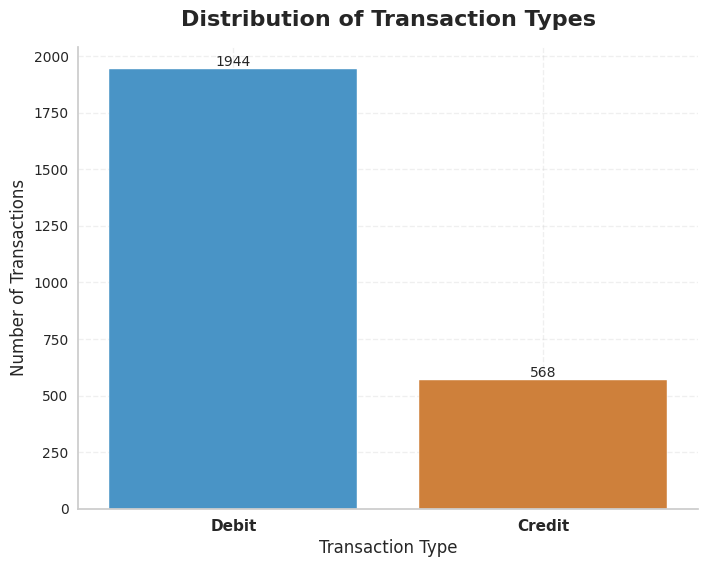

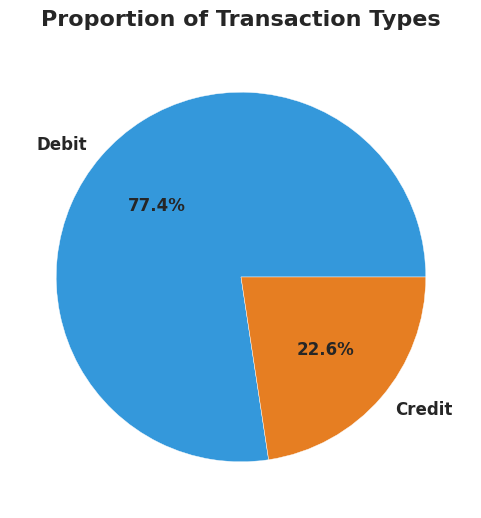

In [13]:
# Distribusi tipe transaksi
style_plot(fig_size=(8, 6), title='Distribution of Transaction Types',
           xlabel='Transaction Type',
           ylabel='Number of Transactions')

sns.countplot(x='TransactionType', data=df, palette=['#3498db', '#e67e22'])
ax = plt.gca()
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=10)

plt.xticks(fontsize=11, weight='bold')
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()

# Plot dengan bentuk pie chart
plt.figure(figsize=(6, 6))
df['TransactionType'].value_counts().plot.pie(autopct='%1.1f%%', colors=['#3498db', '#e67e22'],
                                              textprops={'fontsize': 12, 'weight': 'bold'})
plt.title('Proportion of Transaction Types', fontsize=16, weight='bold', pad=15)
plt.ylabel('')
plt.show()

Jumlah pengguna yang menggunakan debit jauh lebih banyak dibanding yang menggunakan credit card. Dengan perbandingan:


```
# Debit 77.4%
# Credit 22.6%
```

# **5. Data Preprocessing**

Beberapa hal yang saya lakukan dari dataset sebelum masuk ke pembuatan model adalah sebagai berikut ini:
1. Menghapus atau Menangani Data Kosong (Missing Values)
2. Menghapus Data Duplikat
3. Normalisasi atau Standarisasi Fitur
4. Deteksi dan Penanganan Outlier
5. Encoding Data Kategorikal
6. Binning (Pengelompokan Data)

Sebelum masuk ke pelatihan model, terdapat hal yang perlu dilakukan kepada dataset:
* Encoding fitur kategorikal (TransactionType, Location, Channel) agar bisa digunakan dalam model clustering.
* Normalisasi fitur numerik untuk menyamakan skala.

Dataset harus sudah berhasil dinormalisasi dan dikonversi ke bentuk numerik.

In [14]:
# Kolom yang berfungsi sebagai identifier saya hapus karena tidak akan valid bilag digunakan dalam feature di clustering
df = df.drop(columns=['TransactionID', 'AccountID', 'DeviceID',  'IP Address', 'MerchantID', 'TransactionDate', 'PreviousTransactionDate'])

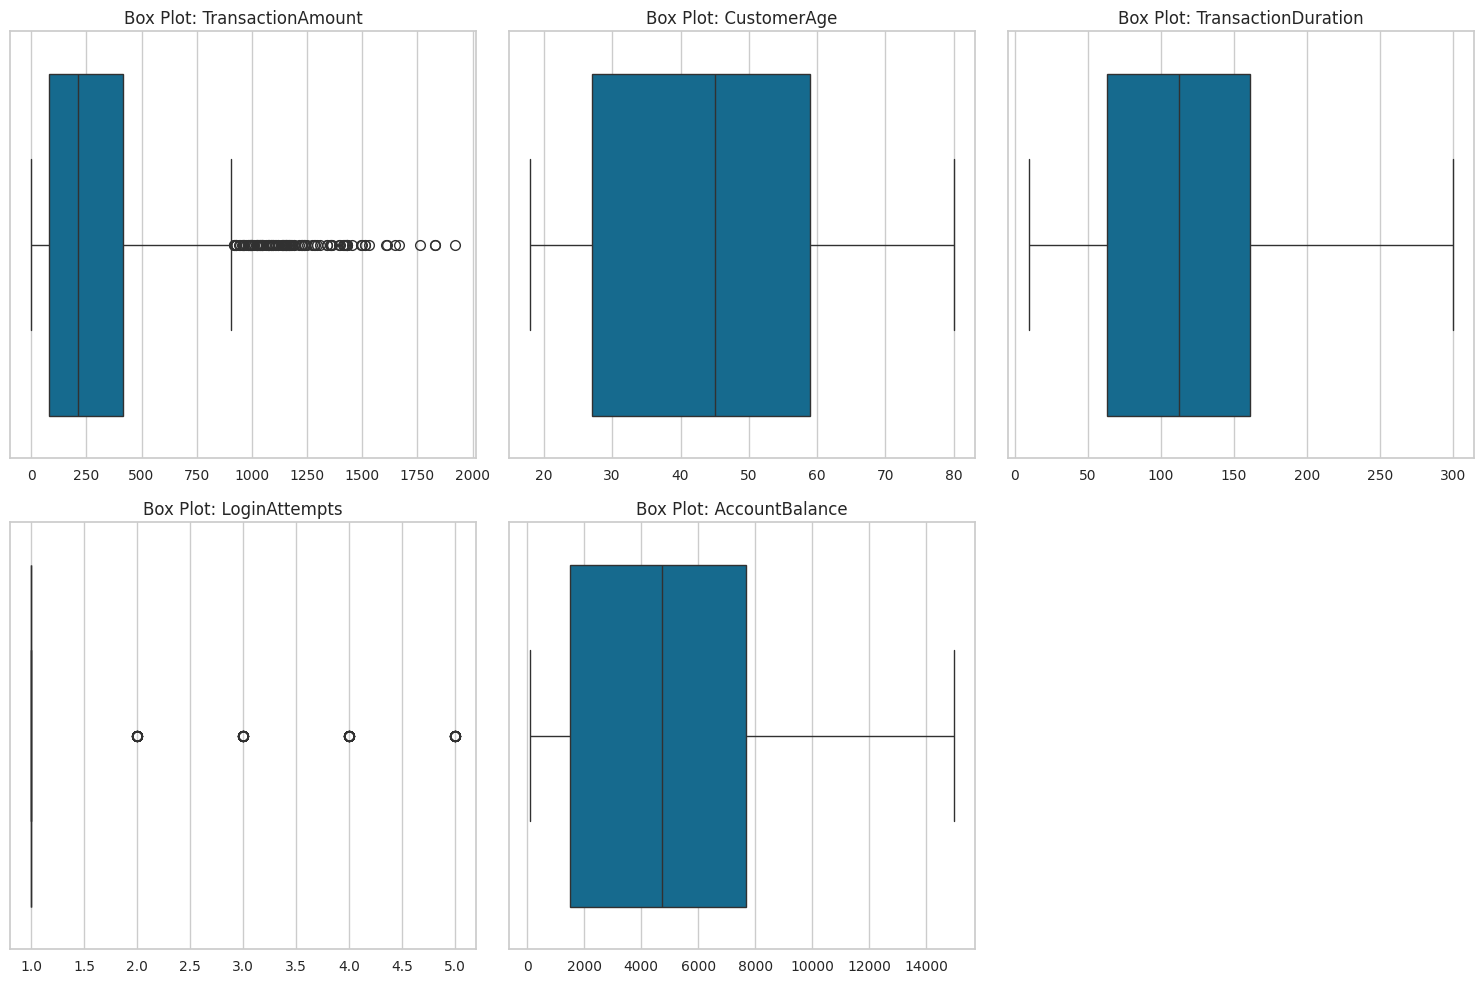

In [15]:
# Menentukan fitur numerik dalam dataset
numerical_features = df.select_dtypes(include=['number']).columns

# Menyesuaikan jumlah baris untuk menampilkan semua fitur dalam grid 3 kolom
num_features = len(numerical_features)
rows = (num_features // 3) + (num_features % 3 > 0)

# Membuat subplots untuk visualisasi box plot
fig, axes = plt.subplots(rows, 3, figsize=(15, 5 * rows))
axes = axes.flatten()

# Loop untuk membuat box plot setiap fitur numerik
for i, feature in enumerate(numerical_features):
    sns.boxplot(x=df[feature], ax=axes[i])
    axes[i].set_title(f'Box Plot: {feature}')
    axes[i].set_xlabel("")

# Menghapus subplot kosong jika ada
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [16]:
# Salin data untuk menjaga dataset asli tetap utuh
df_cleaned = df.copy()

# Menghitung Q1, Q3, dan IQR untuk setiap fitur numerik
Q1 = df_cleaned[numerical_features].quantile(0.25)
Q3 = df_cleaned[numerical_features].quantile(0.75)
IQR = Q3 - Q1

# Menentukan kondisi untuk menyaring data yang tidak mengandung outlier
non_outlier_condition = ~((df_cleaned[numerical_features] < (Q1 - 1.5 * IQR)) |
                          (df_cleaned[numerical_features] > (Q3 + 1.5 * IQR))).any(axis=1)

# Menyaring data numerik tanpa outlier
df_filtered_numeric = df_cleaned.loc[non_outlier_condition, numerical_features]

# Menggabungkan kembali dengan fitur kategorikal
categorical_features = df.select_dtypes(include=['object']).columns
df_cleaned = pd.concat([df_filtered_numeric, df_cleaned.loc[non_outlier_condition, categorical_features]], axis=1)

In [17]:
# Menampilkan informasi setelah outlier dihapus
print("Hasil setelah menghapus outlier:")
print(df_cleaned.head())

Hasil setelah menghapus outlier:
   TransactionAmount  CustomerAge  TransactionDuration  LoginAttempts  \
0              14.09           70                   81              1   
1             376.24           68                  141              1   
2             126.29           19                   56              1   
3             184.50           26                   25              1   
4              13.45           26                  198              1   

   AccountBalance TransactionType   Location Channel CustomerOccupation  
0         5112.21           Debit  San Diego     ATM             Doctor  
1        13758.91           Debit    Houston     ATM             Doctor  
2         1122.35           Debit       Mesa  Online            Student  
3         8569.06           Debit    Raleigh  Online            Student  
4         7429.40          Credit    Atlanta  Online            Student  


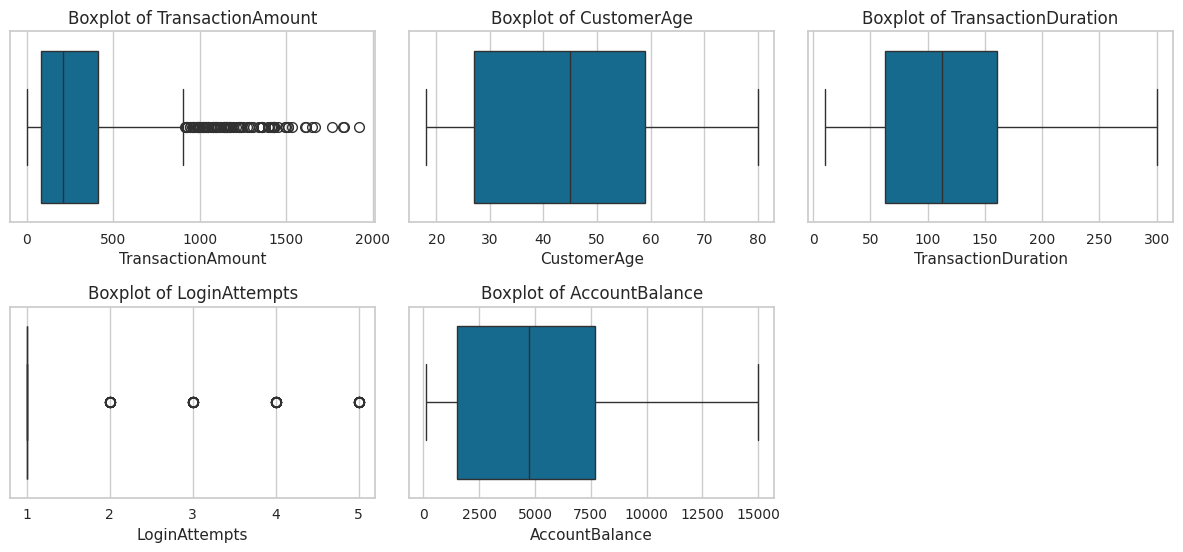

In [18]:
# boxplot setelah penanganan outliers
plt.figure(figsize=(12,8))

numerical_features = df.select_dtypes(include=['number']).columns
for i, col in enumerate(numerical_features, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()

In [19]:
df_cleaned

,TransactionAmount,CustomerAge,TransactionDuration,LoginAttempts,AccountBalance,TransactionType,Location,Channel,CustomerOccupation
0,14.09,70,81,1,5112.21,Debit,San Diego,ATM,Doctor
1,376.24,68,141,1,13758.91,Debit,Houston,ATM,Doctor
2,126.29,19,56,1,1122.35,Debit,Mesa,Online,Student
3,184.50,26,25,1,8569.06,Debit,Raleigh,Online,Student
4,13.45,26,198,1,7429.40,Credit,Atlanta,Online,Student
...,...,...,...,...,...,...,...,...,...
2507,856.21,33,109,1,12690.79,Credit,Colorado Springs,Branch,Doctor
2508,251.54,48,177,1,254.75,Debit,Tucson,Branch,Doctor
2509,28.63,56,146,1,3382.91,Debit,San Diego,Branch,Retired
2510,185.97,23,19,1,1776.91,Debit,Denver,Online,Student


In [20]:
# standarisasi fitur
scaler = StandardScaler()

numerical_features = df.select_dtypes(include=np.number).columns
df_standardized = df_cleaned

df_standardized[numerical_features] = scaler.fit_transform(df_standardized[numerical_features])

print("Data setelah standarisasi:")
print(df_standardized)

Data setelah standarisasi:
      TransactionAmount  CustomerAge  TransactionDuration  LoginAttempts  \
0             -1.108794     1.429702            -0.543725            0.0   
1              0.554382     1.316759             0.315402            0.0   
2             -0.593515    -1.450340            -0.901695            0.0   
3             -0.326185    -1.055040            -1.345577            0.0   
4             -1.111734    -1.055040             1.131573            0.0   
...                 ...          ...                  ...            ...   
2507           2.758647    -0.659740            -0.142799            0.0   
2508          -0.018304     0.187331             0.830879            0.0   
2509          -1.042019     0.639102             0.386996            0.0   
2510          -0.319434    -1.224455            -1.431490            0.0   
2511          -0.057156    -1.167983            -0.371899            0.0   

      AccountBalance TransactionType          Location Chann

In [21]:
# Dataset yang selesai dibersihkan dikonfersi dengan label df_encoded
encoder = CountFrequencyEncoder(
    encoding_method = 'frequency',
    variables = ['TransactionType', 'Location', 'Channel', 'CustomerOccupation'],
    ignore_format=True,
    missing_values='ignore'
)
df_encoded = df.copy()
df_encoded = encoder.fit_transform(df_standardized)

print("Data setelah encoding:")
print(df_encoded)

Data setelah encoding:
      TransactionAmount  CustomerAge  TransactionDuration  LoginAttempts  \
0             -1.108794     1.429702            -0.543725            0.0   
1              0.554382     1.316759             0.315402            0.0   
2             -0.593515    -1.450340            -0.901695            0.0   
3             -0.326185    -1.055040            -1.345577            0.0   
4             -1.111734    -1.055040             1.131573            0.0   
...                 ...          ...                  ...            ...   
2507           2.758647    -0.659740            -0.142799            0.0   
2508          -0.018304     0.187331             0.830879            0.0   
2509          -1.042019     0.639102             0.386996            0.0   
2510          -0.319434    -1.224455            -1.431490            0.0   
2511          -0.057156    -1.167983            -0.371899            0.0   

      AccountBalance  TransactionType  Location   Channel  Custo

# **6. Pembangunan Model Clustering**

## **a. Pembangunan Model Clustering**

Dalam pembangunan model clustering beberapa tahap yang saya lakukan adalah:
* Menentukan jumlah cluster optimal menggunakan Elbow Method dan Silhouette Score.
* Melakukan clustering menggunakan K-Means dan Hierarchical Clustering.
* Evaluasi hasil clustering.

In [22]:
print(df_encoded.dtypes)

TransactionAmount      float64
CustomerAge            float64
TransactionDuration    float64
LoginAttempts          float64
AccountBalance         float64
TransactionType        float64
Location               float64
Channel                float64
CustomerOccupation     float64
dtype: object


In [23]:
# Membuat model KMeans dengan 4 cluster
kmeans_model = KMeans(n_clusters=4, random_state=42)
cluster_labels = kmeans_model.fit_predict(df_encoded)

# Menghitung silhouette score hanya untuk 4 cluster
silhouette_avg = silhouette_score(df_encoded[numerical_features], cluster_labels)

data_array = np.asarray(df_encoded)

# Menerapkan PCA untuk mengurangi komponen utama
pca_model = PCA(n_components=2, random_state=24)
data_pca = pca_model.fit_transform(data_array)

# Melakukan clustering dengan K-Means pada data hasil PCA
kmeans_model = KMeans(n_clusters=4, random_state=42)
cluster_labels = kmeans_model.fit_predict(data_pca)

# Menghitung dan mencetak Silhouette Score
silhouette_avg = silhouette_score(data_pca, cluster_labels)

In [24]:
# Inisialisasi model KMeans tanpa parameter awal
kmeans = KMeans()

# Inisialisasi visualizer KElbow untuk menentukan jumlah cluster optimal
visualizer = KElbowVisualizer(kmeans, k=(1, 10))

## **b. Evaluasi Model Clustering**

Untuk menentukan jumlah cluster yang optimal dalam model clustering, saya menggunakan metode Elbow atau Silhouette Score.

Metode ini bisa untuk menemukan jumlah cluster yang memberikan pemisahan terbaik antar kelompok data, sehingga model yang dibangun dapat lebih efektif. Yaitu menggunakan Silhouette Score dan Elbow Method untuk menentukan jumlah cluster optimal.

In [25]:
print(f"Silhouette Score untuk 4 cluster: {silhouette_avg}")

Silhouette Score untuk 4 cluster: 0.3383355422365107


**Insight**: Hasil dari Silhouette Score masih menunjukan nilai yang cukup rendah sehingga perlu melakukan Feature Selection untuk melihat apakah bisa terdapat perubahan atau peningkatan yang bisa dilakukan.

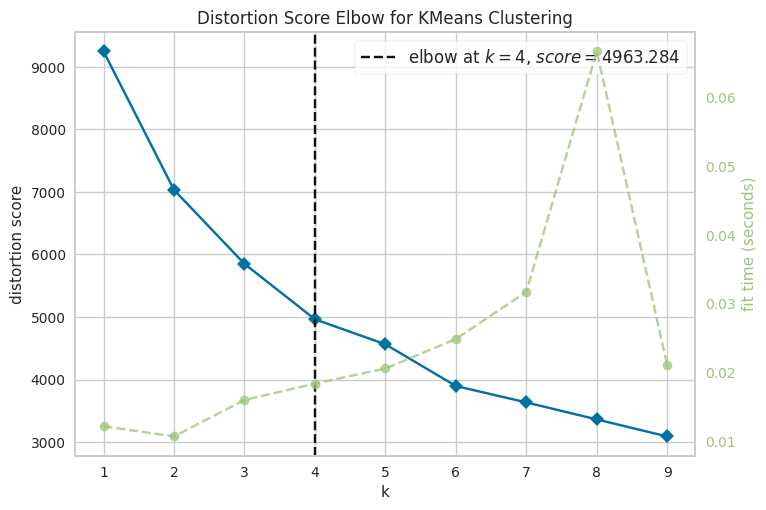

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [26]:
# Inisialisasi model KMeans tanpa parameter awal
kmeans = KMeans()

# Inisialisasi visualizer KElbow untuk menentukan jumlah cluster optimal
visualizer = KElbowVisualizer(kmeans, k=(1, 10))

# Fit visualizer dengan data untuk menemukan jumlah cluster optimal
visualizer.fit(df_encoded)

# Menampilkan grafik elbow untuk analisis
visualizer.show()

**Insight**: Berdasarkan hasil menunjukan bahwa titik berada pada posisi saat cluster 4.

## **c. Feature Selection (Opsional)**

Saya menggunakan metode PCA (Principal Component Analysis) dan One-Hot Encoding untuk proses feature transformation sebelum melakukan clustering. PCA digunakan untuk mereduksi dimensi fitur numerik setelah dilakukan standarisasi, dengan tujuan menyederhanakan kompleksitas data dan mengeliminasi redundansi antar fitur.

Sementara itu, fitur kategorikal diolah menggunakan OneHotEncoder agar setiap kategori dapat direpresentasikan secara numerik dan dapat digabungkan bersama fitur PCA. Hasil gabungan fitur-fitur inilah yang digunakan sebagai input utama dalam proses clustering.

In [27]:
# Menambahkan hasil clustering ke dalam DataFrame
df_encoded['Cluster'] = cluster_labels

# Fungsi untuk menganalisis karakteristik setiap cluster
def analyze_clusters(df, num_clusters):
    print("Analisis Karakteristik Setiap Cluster")
    for i in range(num_clusters):
        # Memfilter data berdasarkan cluster
        cluster_subset = df[df['Cluster'] == i]

        # Menghitung rata-rata fitur numerik
        cluster_means = cluster_subset.mean(numeric_only=True)

        print(f"\nCluster {i + 1}")
        print(cluster_means)

# Menjalankan analisis untuk 4 cluster
analyze_clusters(df_encoded, 4)

Analisis Karakteristik Setiap Cluster

Cluster 1
TransactionAmount      0.808637
CustomerAge            0.471174
TransactionDuration   -0.614992
LoginAttempts          0.000000
AccountBalance         0.421513
TransactionType        0.643687
Location               0.023474
Channel                0.333678
CustomerOccupation     0.246083
Cluster                0.000000
dtype: float64

Cluster 2
TransactionAmount      0.659474
CustomerAge           -0.981864
TransactionDuration   -0.467745
LoginAttempts          0.000000
AccountBalance        -0.921022
TransactionType        0.644365
Location               0.023553
Channel                0.333853
CustomerOccupation     0.258300
Cluster                1.000000
dtype: float64

Cluster 3
TransactionAmount     -0.557861
CustomerAge            0.637316
TransactionDuration    0.258458
LoginAttempts          0.000000
AccountBalance         0.606194
TransactionType        0.648127
Location               0.023519
Channel                0.333973
Cus

In [28]:
data_array = np.asarray(df_encoded)

# Menerapkan PCA untuk mengurangi komponen utama sekaligus meningkatkan silhouette score
pca_model = PCA(n_components=2, random_state=24)
data_pca = pca_model.fit_transform(data_array)

# Melakukan clustering dengan K-Means pada data hasil PCA
kmeans_model = KMeans(n_clusters=4, random_state=42)
cluster_labels = kmeans_model.fit_predict(data_pca)

# Menghitung dan mencetak Silhouette Score
silhouette_avg = silhouette_score(data_pca, cluster_labels)
print(f"Silhouette Score untuk 4 cluster: {silhouette_avg}")

Silhouette Score untuk 4 cluster: 0.5827046963549055


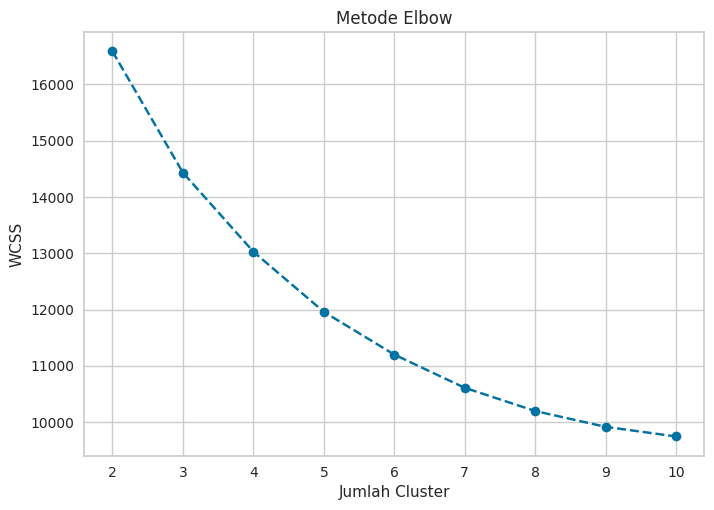

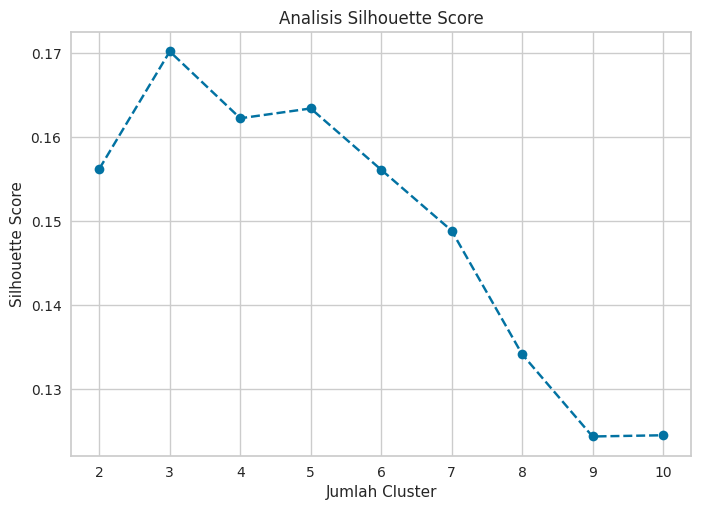

Silhouette Score: 0.1702


In [29]:
# 1. Memisahkan fitur numerik dan kategorikal
numeric_features = df.select_dtypes(include=['int64', 'float64']).columns
categorical_features = df.select_dtypes(include=['object']).columns

# 2. Standarisasi fitur numerik
scaler = StandardScaler()
df_scaled_numeric = scaler.fit_transform(df[numeric_features])

# 3. Dimensi reduksi dengan PCA untuk fitur numerik
pca = PCA(n_components=min(5, len(numeric_features)))
df_pca_numeric = pca.fit_transform(df_scaled_numeric)

# 4. Encoding fitur kategorikal
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
df_encoded_cat = encoder.fit_transform(df[categorical_features])
categorical_feature_names = encoder.get_feature_names_out(categorical_features)

# 5. Gabungkan fitur numerik (PCA) dan fitur kategorikal (encoded)
df_final_features = np.hstack((df_pca_numeric, df_encoded_cat))
pca_feature_names = [f'PCA{i+1}' for i in range(df_pca_numeric.shape[1])]
feature_names = np.array(pca_feature_names + list(categorical_feature_names))
df_selected = pd.DataFrame(df_final_features, columns=feature_names)

# 6. Metode Elbow dan Silhouette untuk memilih jumlah cluster
def elbow_method(data, max_clusters=10):
    wcss = [KMeans(n_clusters=i, random_state=42).fit(data).inertia_ for i in range(2, max_clusters + 1)]
    plt.plot(range(2, max_clusters + 1), wcss, marker='o', linestyle='--')
    plt.xlabel('Jumlah Cluster')
    plt.ylabel('WCSS')
    plt.title('Metode Elbow')
    plt.grid(True)
    plt.show()

def silhouette_analysis(data, max_clusters=10):
    scores = [silhouette_score(data, KMeans(n_clusters=i, random_state=42).fit_predict(data)) for i in range(2, max_clusters + 1)]
    plt.plot(range(2, max_clusters + 1), scores, marker='o', linestyle='--')
    plt.xlabel('Jumlah Cluster')
    plt.ylabel('Silhouette Score')
    plt.title('Analisis Silhouette Score')
    plt.grid(True)
    plt.show()

# 7. Menjalankan analisis jumlah cluster optimal
elbow_method(df_selected)
silhouette_analysis(df_selected)

# 8. Lakukan clustering dengan jumlah cluster terbaik
optimal_clusters = 3
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
labels = kmeans.fit_predict(df_selected)

# 10. Evaluasi kualitas clustering
silhouette_after = silhouette_score(df_selected, labels)
print(f'Silhouette Score: {silhouette_after:.4f}')

### **Perbandingan hasil sebelum dan sesudah Feature Selection**

In [30]:
# Perbandingan silhouette score
print(f"Silhouette Score sebelum Feature Selection: {silhouette_avg}")
print(f"Silhouette Score setelah Feature Selection: {silhouette_after:.4f}")

Silhouette Score sebelum Feature Selection: 0.5827046963549055
Silhouette Score setelah Feature Selection: 0.1702


**Insight**: Hasil yang didapat dari penggunaan PCA lebih tinggi dibandingkan dengan PCA model dibandingkan dengan gabungan antara PCA dan fitur kategorikal

## **d. Visualisasi Hasil Clustering**

Menampilkan hasil clustering melalui visualisasi, hasil clustering dalam bentuk visualisasi, seperti grafik scatter plot dan 2D PCA projection.

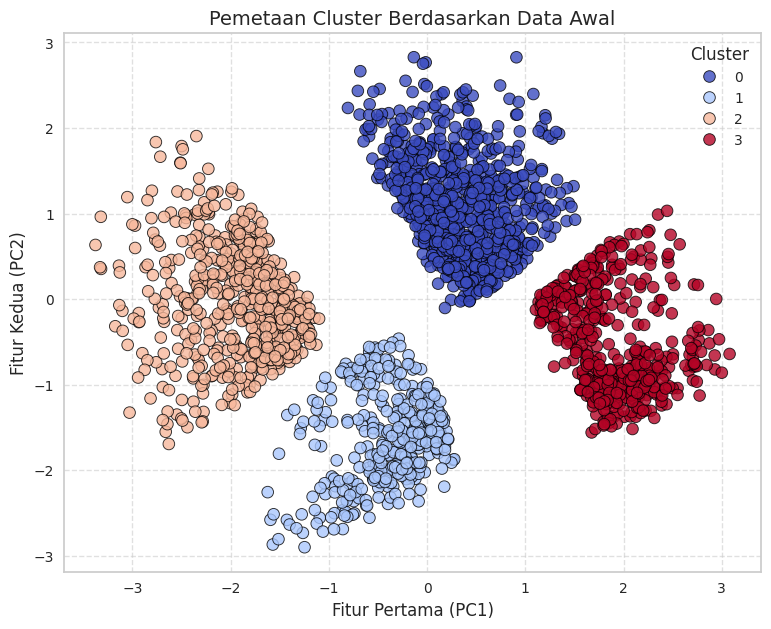

In [31]:
# Reduksi dimensi jika menggunakan PCA
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_encoded)

# Jalankan clustering di data yang sama
kmeans = KMeans(n_clusters=4, random_state=42)
labels = kmeans.fit_predict(df_pca)

# Gunakan df_pca untuk plotting
df_plot = pd.DataFrame(df_pca, columns=['PC1', 'PC2'])
df_plot['Cluster'] = labels

plt.figure(figsize=(9, 7))
sns.scatterplot(
    x=df_plot['PC1'],
    y=df_plot['PC2'],
    hue=df_plot['Cluster'],
    palette='coolwarm',
    edgecolor='black',
    s=70,
    alpha=0.8
)

plt.title('Pemetaan Cluster Berdasarkan Data Awal', fontsize=14)
plt.xlabel('Fitur Pertama (PC1)', fontsize=12)
plt.ylabel('Fitur Kedua (PC2)', fontsize=12)
plt.legend(title="Cluster", loc='best')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

## **e. Analisis dan Interpretasi Hasil Cluster**

### Interpretasi Target

In [32]:
# Kolom cluster baru yang telah dibuat oleh model ini
df_encoded[numerical_features] = scaler.inverse_transform(df_encoded[numerical_features])

In [33]:
df_encoded['Cluster'] = labels
print(df_encoded.head())

   TransactionAmount  CustomerAge  TransactionDuration  LoginAttempts  \
0         -26.050139    70.106437            81.609851       1.124602   
1         459.411187    68.097336           141.705651       1.124602   
2         124.353729    18.874361            56.569934       1.124602   
3         202.384113    25.906215            25.520437       1.124602   
4         -26.908058    25.906215           198.796662       1.124602   

   AccountBalance  TransactionType  Location   Channel  CustomerOccupation  \
0     5106.925758         0.773006  0.022349  0.328659            0.249343   
1    13797.291182         0.773006  0.024540  0.328659            0.249343   
2     1096.917155         0.773006  0.024540  0.321648            0.261613   
3     8581.232686         0.773006  0.024102  0.321648            0.261613   
4     7435.817457         0.226994  0.024978  0.321648            0.261613   

   Cluster  
0        0  
1        0  
2        1  
3        2  
4        3  


### Inverse Data Jika Melakukan Normalisasi/Standardisasi

In [34]:
# Menghitung rata-rata keseluruhan dataset
overall_mean = df_encoded.mean(numeric_only=True)
print("Rata-rata Keseluruhan DataFrame:\n", overall_mean)

# Menghitung rata-rata setiap cluster
cluster_means = df_encoded.groupby('Cluster').agg('mean')

# Fungsi untuk menyorot nilai maksimum di setiap kolom
def highlight_max(data):
    return ['background-color: lightgreen' if v == data.max() else '' for v in data]

# Menerapkan styling pada tabel cluster_means
styled_cluster_means = cluster_means.style.apply(highlight_max, axis=0).format("{:.2f}")

Rata-rata Keseluruhan DataFrame:
 TransactionAmount       297.593778
CustomerAge              44.673965
TransactionDuration     119.643312
LoginAttempts             1.124602
AccountBalance         5114.302966
TransactionType           0.649065
Location                  0.023559
Channel                   0.333759
CustomerOccupation        0.250242
Cluster                   1.334794
dtype: float64


In [35]:
# Menghitung rata-rata setiap fitur berdasarkan cluster
df_cluster_summary = df_encoded.groupby('Cluster').mean(numeric_only=True).T
df_cluster_summary = df_cluster_summary.rename_axis(None, axis=1)
df_cluster_summary = df_cluster_summary.style.format("{:.2f}").background_gradient(cmap='Blues')

display(df_cluster_summary)

,0,1,2,3
TransactionAmount,134.76,490.09,533.63,151.49
CustomerAge,56.01,27.21,53.06,30.06
TransactionDuration,137.72,86.92,76.62,163.26
LoginAttempts,1.12,1.12,1.12,1.12
AccountBalance,7478.56,1522.16,6758.27,2145.24
TransactionType,0.65,0.64,0.64,0.66
Location,0.02,0.02,0.02,0.02
Channel,0.33,0.33,0.33,0.33
CustomerOccupation,0.25,0.26,0.25,0.26


# Analisis Karakteristik Cluster dari Model KMeans

Cluster 0:  
- **Rata-rata TransactionAmount:** 134.76
- **Rata-rata CustomerAge:** 56.01
- **Rata-rata AccountBalance:** 7478.56
- **TransactionDuration:** 137.72
- **LoginAttempts:** 1.12
- **Analisis:** menunjukkan pola pengguna dengan usia yang relatif tua, memiliki saldo akun tinggi, dan melakukan transaksi dalam jumlah kecil. Durasi transaksi juga tergolong tinggi, namun nilai transaksi dan saldo yang stabil menunjukkan aktivitas yang konsisten dan tidak mencurigakan. Karakteristik ini mengindikasikan pengguna reguler dengan kebiasaan transaksi yang aman dan terkontrol.

Cluster 1:
- **Rata-rata TransactionAmount:** 490.09
- **Rata-rata CustomerAge:** 27.21
- **Rata-rata AccountBalance:** 1522.16
- **TransactionDuration:** 86.92
- **LoginAttempts:** 1.12
- **Analisis:** pengguna muda dengan saldo akun yang rendah, namun melakukan transaksi dalam jumlah besar. Kombinasi ini tidak umum dan berpotensi mencurigakan, terutama karena tidak selaras antara usia pengguna, saldo yang terbatas, dan nilai transaksi yang tinggi. Pola ini sesuai dengan karakteristik transaksi fraud yang agresif dalam jumlah besar meskipun dana terbatas.

Cluster 2:
- **Rata-rata TransactionAmount:** 533.63
- **Rata-rata CustomerAge:** 53.06
- **Rata-rata AccountBalance:** 6758.27
- **TransactionDuration:** 76.62
- **LoginAttempts:** 1.12
- **Analisis:** Pengguna berusia paruh baya dengan saldo akun tinggi dan transaksi dalam jumlah besar, tetapi tetap seimbang dengan kemampuan finansialnya. Durasi transaksi relatif cepat, yang menunjukkan proses berjalan lancar. Karakteristik ini menunjukkan pengguna dengan kapasitas transaksi yang besar namun sah, dan cenderung bukan merupakan aktivitas fraud.

Cluster 3:
- **Rata-rata TransactionAmount:** 151.49
- **Rata-rata CustomerAge:** 30.06
- **Rata-rata AccountBalance:** 2145.24
- **TransactionDuration:** 163.26
- **LoginAttempts:** 1.12
- **Analisis:** pengguna muda dengan saldo akun rendah dan transaksi bernilai kecil, namun dengan durasi transaksi yang tinggi. Lama waktu transaksi dapat mengindikasikan adanya kendala sistem atau pemeriksaan tambahan, yang bisa terjadi akibat deteksi anomali oleh sistem. Meskipun nominalnya kecil, pola ini bisa dikaitkan dengan strategi fraud skala kecil dan berulang.

```
# Insight: Dari hasil analisis tersebut, cluster yang kemungkinan termasuk ke dalam jenis fraud adalah cluster 1 dan 3.
```

In [36]:
# Menambahkan kolom label klasifikasi berdasarkan hasil cluster
# Cluster 1 dan 3 dianggap sebagai fraud (1), lainnya sebagai bukan fraud (0)
df_encoded['Label'] = df_encoded['Cluster'].apply(lambda x: 1 if x in [1, 3] else 0)

# Menghapus kolom Cluster karena sudah tidak diperlukan
df_encoded.drop(columns=['Cluster'], inplace=True)

# Mengecek distribusi label
print(df_encoded['Label'].value_counts())

df_encoded.head()

Label
0    1392
1     890
Name: count, dtype: int64


,TransactionAmount,CustomerAge,TransactionDuration,LoginAttempts,AccountBalance,TransactionType,Location,Channel,CustomerOccupation,Label
0,-26.050139,70.106437,81.609851,1.124602,5106.925758,0.773006,0.022349,0.328659,0.249343,0
1,459.411187,68.097336,141.705651,1.124602,13797.291182,0.773006,0.024540,0.328659,0.249343,0
2,124.353729,18.874361,56.569934,1.124602,1096.917155,0.773006,0.024540,0.321648,0.261613,1
3,202.384113,25.906215,25.520437,1.124602,8581.232686,0.773006,0.024102,0.321648,0.261613,0
4,-26.908058,25.906215,198.796662,1.124602,7435.817457,0.226994,0.024978,0.321648,0.261613,1


Karena dataset ini akan digunakan untuk pembuatan model klasifikasi maka dataset perlu diberi label yang dimana disini saya menggunakan label dengan ketentuan sebagai berikut:

```
Label 1: Fraud
Label 0: Bukan Fraud
```

# **7. Mengeksport Data**

Simpan hasilnya ke dalam file CSV.

In [37]:
from google.colab import files

# Menyimpan DataFrame dengan label cluster ke dalam file CSV
df_encoded.to_csv('Dataset_inisiasi.csv', index=False)

Pada project klasifikasi, cluster akan dijadikan label yang akan ditebak oleh model.